In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '31/01/2021'
id_noticia = '250813'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 150

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[1]

In [6]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0].str.replace('*', '')

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,36.585,2.155,321,435,22.559,31/01/2021
1,Cádiz,55.843,2.898,340,850,30.665,31/01/2021
2,Córdoba,38.367,3.059,342,657,25.013,31/01/2021
3,Granada,61.929,4.902,502,1.227,45.065,31/01/2021
4,Huelva,21.172,1.123,60,186,11.393,31/01/2021
5,Jaén,36.335,3.241,274,720,26.181,31/01/2021
6,Málaga,69.052,5.598,416,1.004,40.545,31/01/2021
7,Sevilla,85.338,6.503,620,1.319,58.352,31/01/2021
8,Total,404.621,29.479,2.875,6.398,259.773,31/01/2021


In [7]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [8]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [9]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [10]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [11]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [12]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [13]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-01-31,112.0,4.0,16.0,713.0,8.0
Cádiz,2021-01-31,340.0,8.0,49.0,1293.0,0.0
Córdoba,2021-01-31,80.0,1.0,29.0,456.0,6.0
Granada,2021-01-31,51.0,2.0,15.0,935.0,1.0
Huelva,2021-01-31,114.0,0.0,7.0,448.0,0.0
Jaén,2021-01-31,170.0,1.0,11.0,305.0,1.0
Málaga,2021-01-31,536.0,5.0,56.0,1787.0,2.0
Sevilla,2021-01-31,166.0,1.0,17.0,1955.0,1.0
Total,2021-01-31,1569.0,22.0,200.0,7892.0,19.0


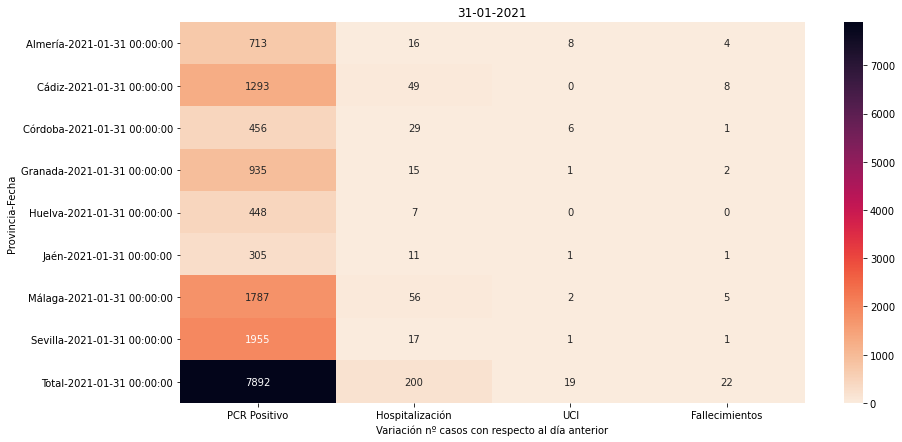

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

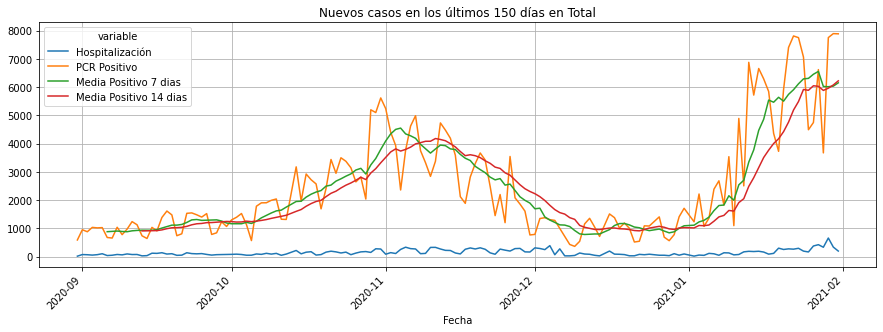

In [15]:
DrawMediaFlotante(df, 'Total', dias_grafico)

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Total,2021-01-31,200.0,0 days
Sevilla,2021-01-31,17.0,0 days
Málaga,2021-01-31,56.0,0 days
Jaén,2021-01-31,11.0,0 days
Huelva,2021-01-31,7.0,0 days
Granada,2021-01-31,15.0,0 days
Córdoba,2021-01-31,29.0,0 days
Cádiz,2021-01-31,49.0,0 days
Almería,2021-01-31,16.0,0 days


In [17]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,UCI,dias
Provincia,,,
Huelva,2021-01-29,2.0,2 days
Cádiz,2021-01-30,7.0,1 days
Total,2021-01-31,19.0,0 days
Sevilla,2021-01-31,1.0,0 days
Málaga,2021-01-31,2.0,0 days
Jaén,2021-01-31,1.0,0 days
Granada,2021-01-31,1.0,0 days
Córdoba,2021-01-31,6.0,0 days
Almería,2021-01-31,8.0,0 days


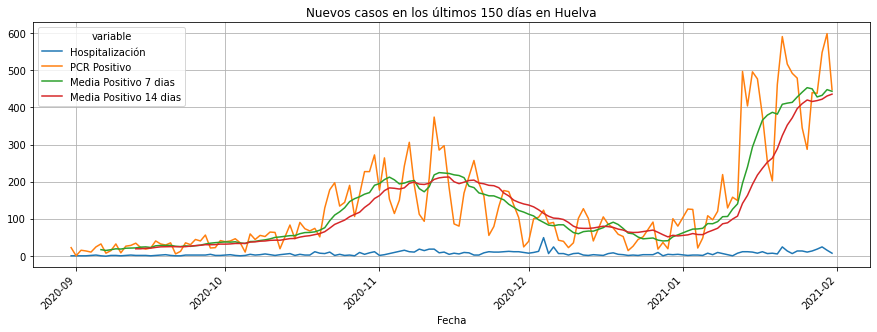

In [18]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

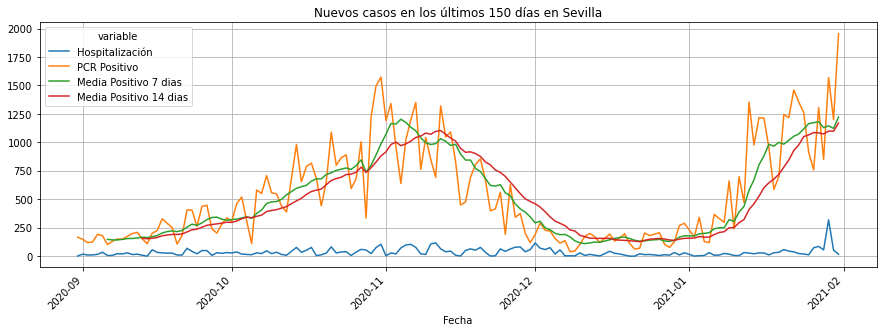

In [19]:
DrawMediaFlotante(df, 'Sevilla', dias_grafico)

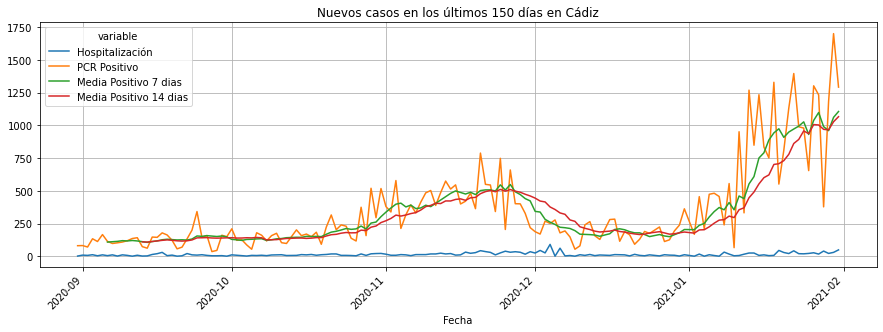

In [20]:
DrawMediaFlotante(df, 'Cádiz', dias_grafico)

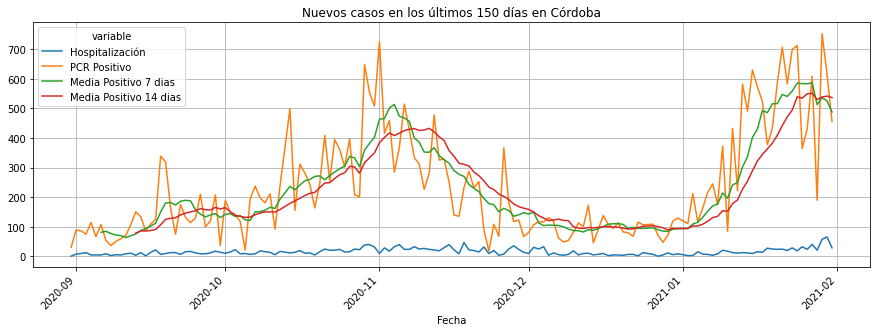

In [21]:
DrawMediaFlotante(df, 'Córdoba', dias_grafico)

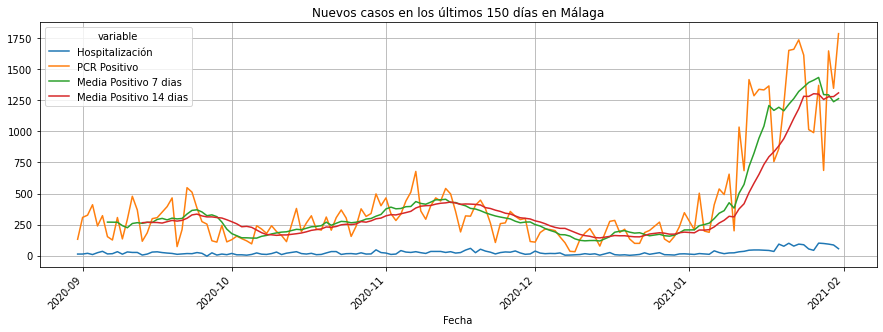

In [22]:
DrawMediaFlotante(df, 'Málaga', dias_grafico)

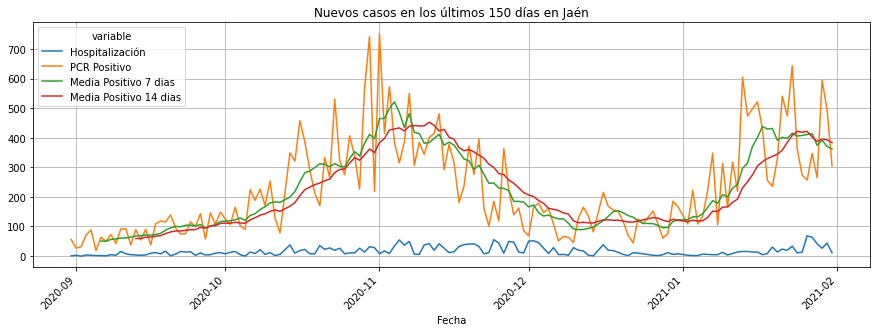

In [23]:
DrawMediaFlotante(df, 'Jaén', dias_grafico)

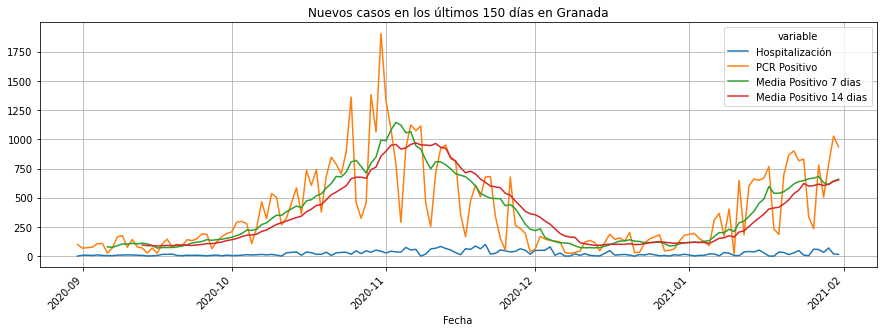

In [24]:
DrawMediaFlotante(df, 'Granada', dias_grafico)

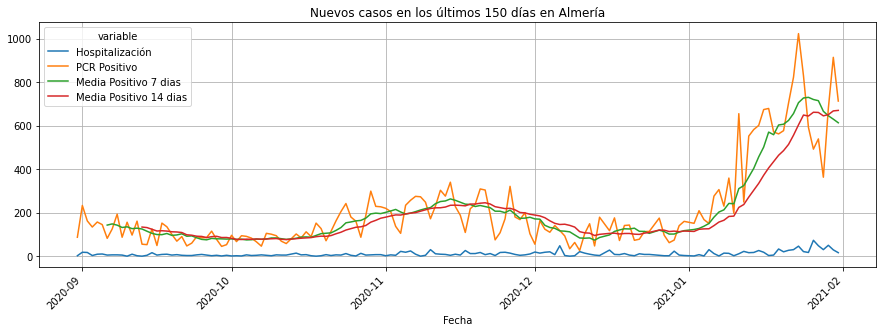

In [25]:
DrawMediaFlotante(df, 'Almería', dias_grafico)